For the final part of my series on Love Island via data analytics I am going to do create models that aim to predict the number of days an islander is expected to stay on the show, as well as which couple is going to win. We will use the data from series 4 as our training set and apply the models to the new data from series 5 to predict outcomes. For this analysis we are going to use a polynomial regression model of order 2, this is due to wanting sure we make sure that try and incorporate the interaction effect between all the features we use. 

In [973]:
from loveisland.common.functions import Functions as F
from loveisland.common.constants import RESULTS_4, RESULTS_5

import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import re
import pandas as pd
import os
import datetime as dt

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.options.mode.chained_assignment = None 

plt.style.use("bmh")

In [974]:
class Arguments():
    def __init__(self, season, bucket="../data/"):
        self.season = season
        self.bucket = bucket

### Predicting the Number of Days an Islander Lasts
For the first part of this analysis we are going try and determine if we can predict the number of days that an islander will last for. There are various ways that islanders are "dumped" from the show, these include being voted off by other islanders, being voted off by the public or by not being in a couple for example, given that the public has a relatively small part to play in the process (even when voting off the contestant the incumbent islanders usually have the final say), therefore the dataset we will be using to train the model is very incomplete. 

In [1047]:
class AggAgg:
    def __init__(self, args):
        self.args = args
        self.df = pd.read_csv(
            os.path.join(args.bucket, "season_" + str(args.season), "agg_df.csv")
        )

    @staticmethod
    def date_to_n_lookup(df):
        n_list = list(range(1, df["dumped"].max() + 1))
        d_list = [(df["date"].min() + dt.timedelta(days=n)).date() for n in n_list]
        return pd.DataFrame.from_dict({"dumped": n_list, "dumped_d": d_list})

    def start_end(self):
        if self.args.season == 4:
            sd, ed = "2018-06-04", "2018-07-30"
        else:
            sd, ed = "2019-06-03", "2019-07-30"

        self.df = self.df[(sd <= self.df["date"]) & (self.df["date"] < ed)].reset_index(
            drop=True
        )
        return self

    def islander_agg(self):
        self.df["date"] = pd.to_datetime(self.df["date"])
        self.start_end()
        self.df = self.df.merge(self.date_to_n_lookup(self.df), on="dumped", how="left")
        self.df["dumped_d"] = pd.to_datetime(self.df["dumped_d"])
        self.df = self.df[
            (self.df["date"] <= self.df["dumped_d"]) | (self.df["dumped"] == 0)
        ].reset_index(drop=True)

        self.df = (
            self.df.groupby(["islander", "date"])
            .agg({"n_tweets": "sum", "score": "mean", "favs": "mean"})
            .reset_index()
        )
        self.df["n_tweets_perc"] = self.df.groupby("date")["n_tweets"].apply(
            lambda x: x * 100 / sum(x)
        )
        self.df = (
            self.df.groupby("islander")
            .agg({"n_tweets": "sum", "score": "mean", "n_tweets_perc": "mean", "favs": "mean"})
            .reset_index()
        )

        self.df = self.df.merge(
            F.get_islander_df(self.args.season), on="islander", how="left"
        )
        return self
    
    def create_dummy(self):
        self.df["male"] = np.where(self.df["sex"] == "male", 1, 0)
        return self

    def create_days(self):
        self.df["n_days"] = np.where(
            self.df["dumped"] == 0,
            59 - self.df["arrived"],
            self.df["dumped"] - self.df["arrived"],
        )
        self.df["n_days_perc"] = self.df["n_days"] / (59 - self.df["arrived"])
        return self
    
def normalize(df, ind_cols=["n_tweets_perc", "score"], dep_col="n_days_perc"):
    for col in ind_cols:
        df = df[df[col].notna()]
        df[col] = preprocessing.normalize([df[col]])[0]
    return df[df[dep_col].notna()]


def fit_mod(df, dep_col="n_days_perc", ind_cols=["n_tweets_perc", "score"]):      
    poly = preprocessing.PolynomialFeatures(degree=2)
    reg = linear_model.LinearRegression()
    reg.fit(poly.fit_transform(df[ind_cols]), df[dep_col])
    return reg, poly


def get_stats(df, reg, poly, dep_col="n_days_perc", ind_cols=["n_tweets_perc", "score"]):    
    print("\033[1mRegression outputs", "\033[0;0m")
    print("x0 = n_tweets_perc\nx1 = mean sentiment score\n")
    print("Intercept:", reg.intercept_, "\n") 

    for c in zip(poly.get_feature_names(), reg.coef_):
        if c[0] != '1':
            print("Coefficient for {}: {}".format(c[0], c[1])) 
            
    print("\nR^2 score:", reg.score(poly.fit_transform(df[ind_cols]), df[dep_col]))


def apply_mod(df, req, poly):
    df["pred"] = df.apply(
        lambda row:reg.predict(poly.fit_transform([[row["n_tweets_perc"], row["score"]]]))[0],
        axis=1)
    df["diff"] = df["n_days_perc"] - df["pred"]
    df["b_o_w"] = np.where(df["diff"] < 0, "worse", "better")
    return df


### Preprocessing 
1. Find mean sentiment score of all tweets about each islander per day, find the percentage of tweets per day that included a direct reference to each islander
2. Filter to only include the days that the islander was in the villa (if an islander left and in reaction to their actions on the outside they may have got a lot of tweets etc, this isn't relevant for predicting something during their time in the villa).
3. Find the mean sentiment score per islander from the days they were in the villa and the mean percentage of tweets about them across all the days they were inside; we want to be "fair" to all islanders, if we simply took the percentage of tweets per all tweets we would be very biased towards islanders who have been their longer, so by taking the average per day, then the average of these, we normalize for islanders who have been on the show for different lengths of times. 
4. Add some metadata to use downstream (islander sex etc)
5. Calculate the proportion of days an islander lasted out of the total number of days they could have stayed. If an islander entered on day 30 and lasted until day 60, then this is only half as many days as someone who entered on day 1 and lasted until day 60, however their available days is half as many so both of these islanders did the best they could and we should account for this - to calculate our dependant variable we shall do: 

`p = (N day the islander left the villa - N day islander entered the villa) / (59 - N day islander entered the villa)`

6. Normalize the independent variables as we know the sentiment score is capped between -1 and 1 with the mean percentage of tweets being uncapped and having a much larger range so normalizing will lead to much more interpretable coefficients.


We will then apply a polynomial regression curve to these features, aiming to predict the proportion of days an islander will stay on the show. My choice to fit a polynomial stems from my assumption that their will be a large interaction between the percentage of tweets an islander receives and the sentiment score behind them, my thinking being that a mid to large percentage of tweets with a positive score will be a better predictor than an huge number of tweets with a score close to zero for example. 




In [1022]:
args = Arguments(4)

agg4 = AggAgg(args)
agg4.islander_agg().create_dummy().create_days()

agg_df4 = normalize(agg4.df)
reg, poly = fit_mod(agg_df4)
agg_df4 = apply_mod(agg_df4, reg, poly)
agg_df4.head()

,islander,n_tweets,score,n_tweets_perc,favs,col,sex,relevant,arrived,dumped,season,male,n_days,n_days_perc,pred,diff,b_o_w
0,adam,81346,-0.025108,0.239505,24.007406,#00958B,male,True,1.0,33.0,4.0,1,32.0,0.551724,0.524974,0.026751,better
1,alex,166048,0.169389,0.350610,23.505778,#E4422D,male,True,1.0,57.0,4.0,1,56.0,0.965517,0.903634,0.061883,better
2,alexandra,29395,0.198138,0.229697,14.770105,#241B23,female,True,39.0,57.0,4.0,0,18.0,0.900000,1.116551,-0.216551,worse
3,charlie,16662,0.129331,0.079573,15.469293,#96C1C7,male,False,26.0,43.0,4.0,1,17.0,0.515152,0.641826,-0.126675,worse
4,dani,78705,0.358257,0.168747,25.760649,#D7D5DC,female,True,1.0,62.0,4.0,0,61.0,1.051724,0.949766,0.101958,better


### Training
Firstly, concentrating on the regression intercept, with 0 tweets and therefore a score of 0 we would expect an islander to last less than 0 days (this is obviously not possible but due to the uncapped nature of the dependent variable it is just a "blind prediction"), it is however evidence to suggest that for contestants to do well they do have to receive a number of tweets about them!

Focusing on the coefficients, we see that there is a positive linear relationship between the percentage of tweets an islander receives a day and the number of days an islander stays for, we do see a negative squared term with nearly double the magnitude of the positive linear term, this might suggest that this relationship is a parabola and that there is a positive relationship up to a point and then over a certain percentage of tweets the expected number of days on the show begins to reduce. Perhaps counterintuitively, the relationship between mean sentiment score squared and proportion of days stayed is negative (both the linear and the squared term are negative), this could however be due to other things such as the way the sentiment analyser deals with tweets where the author is feeling sorry for an islander for example, this relationship however is explained by a positive linear term which would be more in line with expectations. 

Considering the interaction term in our model (the coefficient for x0*x1) we see that this is negative, it is also the largest coefficient so has the greatest impact on the model, this suggests that if an islander receives lots of positive tweets their expected days decreases. Whilst this seems very peculiar it could be explained by a number of hypothesis, for example this could suggest tactical voting by the islanders on the show, often they get the poer to vote off other islanders and ultimately this is a gameshow where the winners win a lot of money, therefore they might be motivated to vote off couples that they deem as popular. This interaction term may be being very biased towards the finalist; for example we know is this series that Alex got very far and he was an islander who received a lot of mixed reactions as well as the fact that Dani and Jack were never really spoken about online (aside from being called boring, ie negative sentiment) but got very far.  

An R-squared term of 0.710 is very, very high (returns a value between 0-1), given that we are predicting human behaviours this especially good, over 70% of the variance within the data is explained by the features of out model! We also know that there will be a lot of noise within the data (due to the nature of sentiment analysis, misspelling on twitter, so this being so high is especially good.

In [1028]:
get_stats(agg_df4, reg, poly)

Regression outputs 
x0 = n_tweets_perc
x1 = mean sentiment score

Intercept: -0.47471969087443555 

Coefficient for x0: 8.124238500832206
Coefficient for x1: 6.2907091802359885
Coefficient for x0^2: -14.449074938577725
Coefficient for x0 x1: -7.838872937744187
Coefficient for x1^2: -10.244043911080084

R^2 score: 0.7096630528873604


Plotting the predicted proportion of days on the show vs the actual number of days on the show we get the following graph. We can see that there is a very positive relationship between the two and without any statistical tests one would say that the model has a pretty good fit. We observe a clustering of islanders who have stayed for nearly the maximum number of days yet are predicted to only last between 70-80% of their maximum number of days - all the islanders in this cluster are the finalists, the majority of them were on the show from the first episode so have a much larger dataset than everyone else, whilst we have tried to normalize for this it does mean that they have a much greater chance of having days with a lot of tweets or with a very low or high sentiment score due to the fact that they were on our screens for so many more days. 

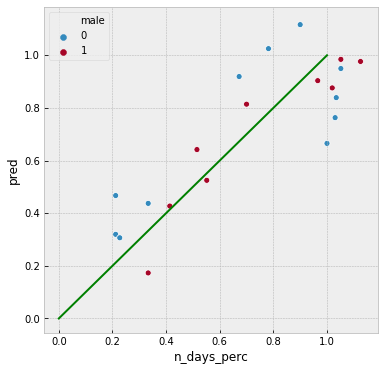

In [1025]:
fig = plt.figure(figsize=(6, 6))

sns.scatterplot("n_days_perc", "pred", "male", data=agg_df4)
sns.lineplot([0,1], [0,1], color="green")

In [1029]:
args = Arguments(5)

agg5 = AggAgg(args)
agg5.islander_agg().create_dummy().create_days()
agg_df5 = normalize(agg5.df)

agg_df5 = apply_mod(agg_df5, reg, poly)
agg_df5.head()

,islander,n_tweets,score,n_tweets_perc,favs,col,sex,relevant,arrived,dumped,season,male,n_days,n_days_perc,pred,diff,b_o_w
0,amber,193932,0.158614,0.292568,44.528754,#5D3BAC,female,True,1,0,5,0,58,1.000000,1.041694,-0.041694,worse
1,amy,108962,0.049867,0.213854,32.348117,#ED4F8A,female,True,1,36,5,0,35,0.603448,0.806501,-0.203053,worse
2,anna,128168,0.090900,0.178376,29.887440,#E4422D,female,True,1,52,5,0,51,0.879310,0.874788,0.004522,better
3,anton,69793,0.135286,0.134493,27.727597,#D7D5DC,male,True,1,0,5,1,58,1.000000,0.877500,0.122500,better
4,arabella,28742,0.016635,0.245171,44.191802,#F7F2F4,female,False,18,25,5,0,7,0.170732,0.718432,-0.547700,worse


### Testing
Given my aim is to predict the winner of Love Island 2019 I want to compare the two series and determine if using last years series as a training set is suitable. In light of this we can use the same model to predict the proportion of potential days an islander will stay in series 5, given the majority have already left we have a lot of validation sources and will be able to determine how good the fit is. 

Focusing on the R-squared term we see a big drop off, this is obviously somewhat expected (one would imagine the model fits worse for testing data compared with the data it was trained one), however the magnitude of the difference is quite large and does suggest that the two series aren't that similar. 

In [1030]:
get_stats(agg_df5, reg, poly)

Regression outputs 
x0 = n_tweets_perc
x1 = mean sentiment score

Intercept: -0.47471969087443555 

Coefficient for x0: 8.124238500832206
Coefficient for x1: 6.2907091802359885
Coefficient for x0^2: -14.449074938577725
Coefficient for x0 x1: -7.838872937744187
Coefficient for x1^2: -10.244043911080084

R^2 score: 0.13240018311883306


Plotting the relationship again is further evidence for a much worse fit. 

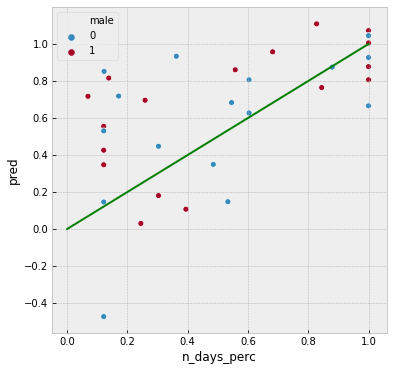

In [1031]:
fig = plt.figure(figsize=(6, 6))

sns.scatterplot("n_days_perc", "pred", "male", data=agg_df5)
sns.lineplot([0,1], [0,1], color="green")

Re-training the model on the data from series 5 we see some interesting differences in the model coefficients, firstly the intercept has decrease dramatically however it is still negative, one would expect this value to be 0 (as simply being on the show means you will get at least a small number of tweets for tabloids etc and no one has ever been on the show less than a day). 

We now again both linear terms as positive with the magnitude of the effect due to sentiment score being a lot larger than the number of tweets. The most notable change is the n_tweets_perc squared term; the magnitude is a lot smaller, this suggests that there is a much weaker relationship between the percentage of tweets per day and the proportion of days an islander stayed on series 5 compared with series 4. We also now see a positive interaction effect which is a lot more in line with what we would assume. 

Even though the coeffitients are much more in line with expecation (positive interaction term and an intercept close to 0), the the fit of this model is worse than the series 4 model. From the graph we again we observe a cluster of finalists that don't fit the model well and also this time a cluster of contestants who entered during Casa Amor and didn't last very long due to not re-coupling, even though the algorithm suggests that they were popular online.  

In [1033]:
reg, poly = fit_mod(agg5.df)
agg_df5 = apply_mod(agg5.df, reg, poly)
get_stats(agg_df5, reg, poly)

Regression outputs 
x0 = n_tweets_perc
x1 = mean sentiment score

Intercept: -0.04241700969431017 

Coefficient for x0: 0.18376511103169138
Coefficient for x1: 2.37509973674735
Coefficient for x0^2: -0.016207101476334224
Coefficient for x0 x1: 0.3933797595346382
Coefficient for x1^2: -10.521558226141035

R^2 score: 0.549837497627599


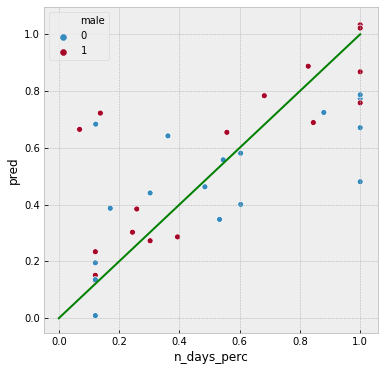

In [1034]:
fig = plt.figure(figsize=(6, 6))

sns.scatterplot("n_days_perc", "pred", "male", data=agg_df5)
sns.lineplot([0,1], [0,1], color="green")

 In conclusion to this first part on predicting the number of potential days each individual islander lasts, we see that we can produce fairly good models using the mean percentage of tweets than mention each islander per day combined with the mean sentiment score per day. We have seen that there are notable differences between series 4 and 5, notably the increase in importance between the relationship between percentage of tweets per day and number of days on the show. To improve these models we could use more features about the individuals, such as sex, ethnicity and age for example, however I did this to compare the features we used to determine if we could use season 4 data to compare couples, which means we wouldn't be able to use these due to complexity and a very small sample size. 

### Predicting the Winner 

In [1035]:
class PredCommon:
    def __init__(self, df):
        self.agg_df = pd.DataFrame()
        self.df = df
            
    def recode_col(self, sdate, edate, d_col):
        self.df["vote"] = np.where(
            (sdate <= self.df[d_col]) & (self.df[d_col] < edate), edate, self.df["vote"],
        )
        return self
    
    def recode_vote(self, d_col="date"):
        if self.args.season == 4:
            dl = ["2018-06-26", "2018-07-04", "2018-07-13", "2018-07-20", "2018-07-24", "2018-07-29"]
        else:
            dl = ["2019-06-26", "2019-07-07", "2019-07-12", "2019-07-19", "2019-07-23", "2019-07-30"]
        
        self.df["vote"] = np.where(self.df[d_col] < dl[0], dl[0], "else")
        for i in range(len(dl)-1):
            self.recode_col(dl[i], dl[i+1], d_col)
        
    def get_totals(self, gb=["vote"]):
        return self.do_agg(gb)[gb + ["n_tweets", "n_users"]].rename(
            columns={"n_tweets": "n_tweets_total", "n_users": "n_users_total"}
        )

    def get_perc(self, col):
        self.agg_df[col + "_perc"] = (
            self.agg_df[col] * 100 / self.agg_df[col + "_total"]
        )
        return self

In [966]:
class AggCouples(PredCommon):
    def __init__(self, args, df):
        PredCommon.__init__(self, df)
        self.args = args

        self.results = self.get_results()
        self.comb = self.get_couples(self.results)

        self.format_res()
        self.recode_vote()
        
    def get_results(self):
        if self.args.season == 4:
            return RESULTS_4
        else:
            return RESULTS_5

    @staticmethod
    def get_couples(results):
        comb = []
        [comb.extend(list(v.keys())) for k, v in results.items()]
        comb = list(set(comb))
        return comb

    def format_res(self):
        recode = {}
        for k0, v0 in self.results.items():
            recode[k0] = {}
            for k1, v1 in self.results[k0].items():
                recode[k0][k1[0] + "_" + k1[1]] = v1
        self.results = recode
        return self

    @staticmethod
    def format_pair(pair):
        pair = [i.lower() for i in pair]
        return pair, pair[0] + "_" + pair[1]

    def do_agg(self, gb=["vote"], ph=None):
        """Aggregate various metrics per couple/date"""
        AGG_JS = {
            "favs": "mean",
            "retwe": "mean",
            "score": "mean",
            "user": "nunique",
            "url": "count",
            "weight_senti": "mean",
        }
        RN_JS = {"url": "n_tweets", "user": "n_users"}

        df = self.df[self.df["score"] != 0]
        if ph is not None:
            df = df[df[ph] == ph]
            gb = gb + [ph]
            RN_JS[ph] = "couple"
        if len(df) > 0:
            return df.groupby(gb).agg(AGG_JS).reset_index().rename(columns=RN_JS)
        return pd.DataFrame()

    def get_agg_df(self):
        for pair in self.comb:
            pair, ph = self.format_pair(pair)
            if pair[0] in self.df.columns and pair[1] in self.df.columns:
                self.df[ph] = np.where(
                    (self.df[pair[0]] == pair[0]) & (self.df[pair[1]] == pair[1]),
                    ph,
                    "nan",
                )

                self.agg_df = self.agg_df.append(
                    self.do_agg(["vote"], ph), sort=True
                ).reset_index(drop=True)

        self.agg_df = self.agg_df.merge(self.get_totals(), on="vote", how="left")
        self.get_perc("n_tweets")
        self.get_perc("n_users")
        return self

    @staticmethod
    def get_split(x, n):
        return x.split("_")[n]

    def add_islanders(self):
        self.agg_df["female"] = self.agg_df["couple"].apply(
            lambda x: self.get_split(x, 0)
        )
        self.agg_df["male"] = self.agg_df["couple"].apply(
            lambda x: self.get_split(x, 1)
        )
        return self

    def get_res(self):
        res = pd.DataFrame.from_dict(self.results).reset_index()
        res = pd.melt(
            res, id_vars=["index"], value_vars=[c for c in res.columns if c != "index"]
        )
        res = res.rename(
            columns={"variable": "vote", "value": "v_share", "index": "couple"}
        )
        res["couple"] = res["couple"].str.lower()
        res["v_max"] = res.groupby(["couple", "vote"])["v_share"].transform(max)
        return (
            res[res["v_max"] == res["v_share"]]
            .drop(columns=["v_max"])
            .reset_index(drop=True)
        )

    def full_df(self):
        self.add_islanders()

        self.agg_df = self.agg_df.merge(
            self.get_res(), on=["vote", "couple"], how="left"
        )
        self.agg_df = self.agg_df[
            (self.agg_df["n_tweets_perc"].notna()) & 
            (self.agg_df["score"].notna()) & 
            (self.agg_df["v_share"].notna()
            )]
        return self


In [1055]:
def get_btn(df):
    tmp = df[df["v_share"] != 1]
    tmp = tmp.groupby(["vote"])["v_share"].agg({"btm": 'count', "v_max":'max'}).reset_index()
    tmp["btm"] = tmp["btm"] / tmp["v_max"]
    return df.merge(tmp, on="vote", how="left")

def get_predictions(reg, df):
    df["pred_v_share"] = df.apply(
        lambda row:reg.predict(poly.fit_transform([[row["n_tweets_perc"], row["score"]]]))[0],
        axis=1
    )
    df["pred_order"] = df.sort_values(by="pred_v_share", ascending=False).groupby("vote").cumcount() + 1
    return get_btn(df)

def validate(df):
    df["rev_order_true"] = df.sort_values(by="v_share", ascending=True).groupby("vote").cumcount() + 1
    df["order_true"] = df.sort_values(by="v_share", ascending=False).groupby("vote").cumcount() + 1
    
    df = df[df["rev_order_true"] <= 2]    
    cols = ["vote", "couple", 'n_tweets_perc', 'score', "v_share", "order_true","pred_v_share", "pred_order"]
    return df[df["order_true"] != df["pred_order"]][cols].sort_values("vote").reset_index(drop=True)
    

def find_accuracy(df):
    df["pos"] = df["pred_order"] / df["v_max"]
    
    df["true_bottom"] = np.where(df["v_share"] == 1.0, True, False)
    df["pred_bottom"] = np.where(df["pos"] > df["btm"], True, False)
    
    cols = ["vote", "couple", 'n_tweets_perc', 'score', "true_bottom", "pred_bottom", "pred_v_share", "pred_order"]
    return df[df["pred_bottom"] != pred_df["true_bottom"]][cols].sort_values("vote").reset_index(drop=True)


In [1041]:
args = Arguments(4)

df = F.import_all(
    os.path.join(args.bucket, "season_" + str(args.season), "processed/")
)
fd4 = AggCouples(args, df)
fd4.get_agg_df().full_df()

agg_df_4 = normalize(fd4.agg_df, dep_col='v_share')

In [1048]:
req, poly = fit_mod(agg_df_4, dep_col='v_share')

In [1050]:
get_stats(agg_df_4, reg, poly, dep_col="v_share")

Regression outputs 
x0 = n_tweets_perc
x1 = mean sentiment score

Intercept: -0.04241700969431017 

Coefficient for x0: 0.18376511103169138
Coefficient for x1: 2.37509973674735
Coefficient for x0^2: -0.016207101476334224
Coefficient for x0 x1: 0.3933797595346382
Coefficient for x1^2: -10.521558226141035

R^2 score: -0.5213056799958358


In [1051]:
pred_df = get_predictions(req, agg_df_4)
validate(pred_df)

/Users/samwatson/projects/loveisland/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,vote,couple,n_tweets_perc,score,v_share,order_true,pred_v_share,pred_order
0,2018-06-26,megan_eyal,0.128186,-0.013831,2.80,6,0.807429,7
1,2018-06-26,zara_adam,0.051756,-0.006528,2.40,7,6.401275,5
2,2018-07-04,ellie_sam,0.009155,0.046738,0.30,8,7.366525,4
3,2018-07-04,darylle_adam,0.006399,0.127314,1.20,7,4.608225,5
4,2018-07-13,megan_wes,0.163124,0.015446,4.20,6,0.887117,7
5,2018-07-13,ellie_charlie,0.018595,0.070407,2.10,7,5.199192,6
6,2018-07-20,kaz_josh,0.081511,0.050095,5.20,5,2.137521,6
7,2018-07-20,laura_jack,0.234566,0.006919,3.30,6,3.999741,5
8,2018-07-24,megan_wes,0.079474,0.049172,7.40,5,2.208967,6
9,2018-07-24,laura_jack,0.198137,0.066007,3.50,6,6.967444,5


/Users/samwatson/projects/loveisland/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


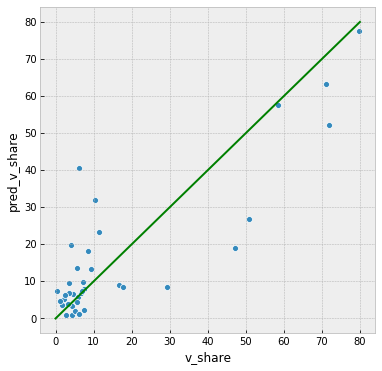

In [1052]:
pred_df = get_predictions(req, agg_df_4)
fig = plt.figure(figsize=(6, 6))

sns.scatterplot("v_share", "pred_v_share", data=pred_df)
sns.lineplot([0,80], [0,80], color="green")

In [1045]:
args = Arguments(5)

df = F.import_all(
    os.path.join(args.bucket, "season_" + str(args.season), "processed/")
)
fd5 = AggCouples(args, df)
fd5.get_agg_df().full_df()

agg_df_5 = normalize(fd5.agg_df, dep_col='v_share')

In [1053]:
get_stats(agg_df_5, reg, poly, dep_col="v_share")

Regression outputs 
x0 = n_tweets_perc
x1 = mean sentiment score

Intercept: -0.04241700969431017 

Coefficient for x0: 0.18376511103169138
Coefficient for x1: 2.37509973674735
Coefficient for x0^2: -0.016207101476334224
Coefficient for x0 x1: 0.3933797595346382
Coefficient for x1^2: -10.521558226141035

R^2 score: -2.918360721149014


In [1056]:
pred_df = get_predictions(req, agg_df_5)
find_accuracy(pred_df)

/Users/samwatson/projects/loveisland/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,vote,couple,n_tweets_perc,score,true_bottom,pred_bottom,pred_v_share,pred_order
0,2019-06-26,amy_curtis,0.131518,0.154605,True,False,10.659575,2
1,2019-06-26,molly_tommy,0.147715,0.057492,False,True,2.654524,6
2,2019-07-07,joanna_michael,0.114409,-0.009730,False,True,1.388492,8
3,2019-07-07,amy_curtis,0.411474,0.038912,True,False,43.418679,2
4,2019-07-07,lucie_george,0.015962,0.034763,True,False,7.448097,4
5,2019-07-07,belle_anton,0.020479,0.172867,False,True,5.284089,6
6,2019-07-19,michael_francesca,0.004566,0.237248,True,False,8.739723,3
7,2019-07-19,belle_anton,0.162971,-0.009144,False,True,0.070450,6
8,2019-07-23,anna_jordan,0.293098,0.047476,True,False,17.477050,3
9,2019-07-23,belle_anton,0.061612,0.212261,False,True,10.491999,6


In [1057]:
print("Model Accuracy:", accuracy_score(pred_df["true_bottom"], pred_df["pred_bottom"]))
print("Model F1 Score:", f1_score(pred_df["true_bottom"], pred_df["pred_bottom"]))

Model Accuracy: 0.7142857142857143
Model F1 Score: 0.5833333333333334
